# OptOut Project: Construct 18-year-long employment sequences for Extended Sample

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta

# set some nicer defaults for matplotlib
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

## Week-to-week crosswalk

Create two functions to convert between week number and calendar year and month

In [2]:
#this is the file to switch between week number in NLSY79 and calendar year, month, and day
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_r26.xlsx') 
weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [3]:
def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = df[(df['Week Start:\nMonth']==month)&(df['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])

    
def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = df[df['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])

## Retrieve Extended Sample

In [4]:
analytic_df = pd.read_csv('../data/analytic_df.csv') #includes fertility data
print analytic_df.shape
analytic_df.head()

(3465, 101)


,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,date_y_2014,y_deceased,last_yr,attr_before35,attr_before35_prev,deceased_before35,y_child18,deceased_child18,deceased_child14,attr_child18
0,2,5,3,2,3,1993,11,1994,-4,-4,...,2014,NaN,2014,False,False,False,2011,False,False,False
1,3,5,3,2,6,1981,10,1983,4,1986,...,2015,NaN,2014,False,False,False,1999,False,False,False
2,8,6,3,2,3,1976,5,1979,9,1982,...,2015,NaN,2014,False,False,False,1994,False,False,False
3,16,5,3,2,2,1990,8,1993,9,1996,...,2015,NaN,2014,False,False,False,2008,False,False,False
4,19,5,3,2,11,1987,-4,-4,-4,-4,...,-5,NaN,2010,False,False,False,2005,False,False,False


## Read weekly arrays and within-job gap dates

In [5]:
#read weekly array data
wkarray_df = pd.read_csv('../data/weeklyarrays.csv')
print wkarray_df.shape
print wkarray_df.columns[:20]

(12686, 3969)
Index([u'caseid_1979', u'hrs_worked_wk_num0000_xrnd',
       u'hrs_worked_wk_num0001_xrnd', u'hrs_worked_wk_num0002_xrnd',
       u'hrs_worked_wk_num0003_xrnd', u'hrs_worked_wk_num0004_xrnd',
       u'hrs_worked_wk_num0005_xrnd', u'hrs_worked_wk_num0006_xrnd',
       u'hrs_worked_wk_num0007_xrnd', u'hrs_worked_wk_num0008_xrnd',
       u'hrs_worked_wk_num0009_xrnd', u'hrs_worked_wk_num0010_xrnd',
       u'hrs_worked_wk_num0011_xrnd', u'hrs_worked_wk_num0012_xrnd',
       u'hrs_worked_wk_num0013_xrnd', u'hrs_worked_wk_num0014_xrnd',
       u'hrs_worked_wk_num0015_xrnd', u'hrs_worked_wk_num0016_xrnd',
       u'hrs_worked_wk_num0017_xrnd', u'hrs_worked_wk_num0018_xrnd'],
      dtype='object')


In [6]:
#read within-job-gap data
gap_df = pd.read_csv("../data/withingaps.csv")
print gap_df.shape
print gap_df.columns[:20]

(12686, 839)
Index([u'caseid_1979', u'per1_start_1979_job01_xrnd',
       u'per1_start_1979_job02_xrnd', u'per1_start_1979_job03_xrnd',
       u'per1_start_1979_job04_xrnd', u'per1_start_1979_job05_xrnd',
       u'per1_stop_1979_job01_xrnd', u'per1_stop_1979_job02_xrnd',
       u'per1_stop_1979_job03_xrnd', u'per1_stop_1979_job04_xrnd',
       u'per1_stop_1979_job05_xrnd', u'per2_start_1979_job01_xrnd',
       u'per2_start_1979_job02_xrnd', u'per2_start_1979_job03_xrnd',
       u'per2_start_1979_job04_xrnd', u'per2_start_1979_job05_xrnd',
       u'per2_stop_1979_job01_xrnd', u'per2_stop_1979_job02_xrnd',
       u'per2_stop_1979_job03_xrnd', u'per2_stop_1979_job04_xrnd'],
      dtype='object')


## Estimate hours worked by age (not part of main analysis)

In [7]:
# (rough) age in 1978
age = 1978 - analytic_df.y_dob
age.value_counts()

16    483
17    479
18    460
19    442
15    437
21    420
20    401
14    343
Name: y_dob, dtype: int64

In [8]:
max_age = 2014 - analytic_df.y_dob
max_age.value_counts()

52    483
53    479
54    460
55    442
51    437
57    420
56    401
50    343
Name: y_dob, dtype: int64

In [9]:
analytic_df['age'] = 1978 - analytic_df.y_dob

In [10]:
# estimate yearly total hours worked by age
d = defaultdict(list)

for i, row in analytic_df.iterrows():
    
    hours_row = wkarray_df[wkarray_df.caseid_1979==row['caseid_1979']].iloc[0]
    
    y = 1978
    
    for j in range(row['age'], 30): # iterate through first available age to age 29
        start = get_week_num(y, 1, 'first')
        end = get_week_num(y, 12, 'last')
        
        hours = [hours_row['hrs_worked_wk_num%04d_xrnd'%week_num] for week_num in range(start, end+1) 
                 if hours_row['hrs_worked_wk_num%04d_xrnd'%week_num]>=0]
        
        d[j].append(sum(hours))
        
        y += 1

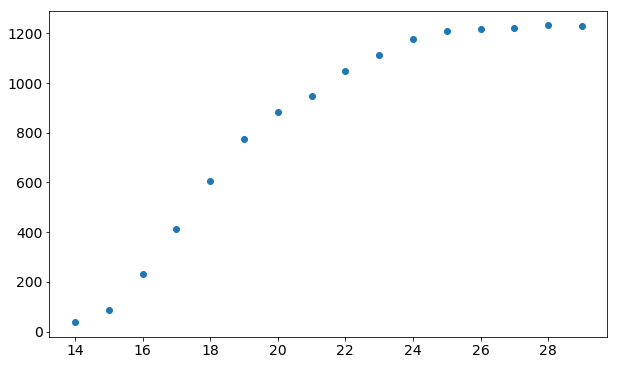

In [23]:
age = range(14, 30)
mean_hours = [np.mean(d[k]) for k in age]
plt.scatter(age, mean_hours)
remove_border()

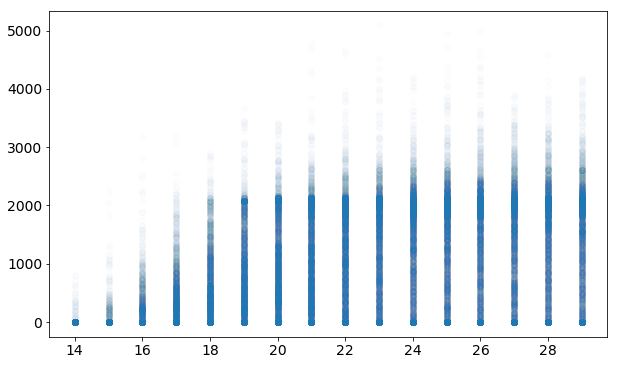

In [25]:
# plot all observations
age = []
hours = []

for (k, l) in d.items():
    for v in l:
        age.append(k)
        hours.append(v)
    
tmp_df = pd.DataFrame({'age':age, 'hours':hours})
    
plt.scatter(tmp_df.age, tmp_df.hours, alpha=0.01)

## Identify maternity leaves

Maternity leave could cover the birth, start after the birth, or end before the birth. 

Let's assume any within-job gap that start or end within 4 months (16 weeks) of birth as maternity leave (there are relatively fewer maternity gaps that finished within 16 weeks before birth, so do not consider within-job gaps that ended within 16 weeks before birth as maternity leave).

In [8]:
merged = analytic_df.merge(gap_df, on='caseid_1979') # merge datasets
merged.columns

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd', u'c1dob_y_xrnd', u'c2dob_m_xrnd',
       u'c2dob_y_xrnd', u'c3dob_m_xrnd', u'c3dob_y_xrnd',
       ...
       u'per3_start_2014_job03_xrnd', u'per3_start_2014_job04_xrnd',
       u'per3_stop_2014_job01_xrnd', u'per3_stop_2014_job02_xrnd',
       u'per3_stop_2014_job03_xrnd', u'per3_stop_2014_job04_xrnd',
       u'per4_start_2014_job01_xrnd', u'per4_start_2014_job02_xrnd',
       u'per4_stop_2014_job01_xrnd', u'per4_stop_2014_job02_xrnd'],
      dtype='object', length=939)

### Write a function to retrieve all valid job gap start and end weeks

In [9]:
missing_data = defaultdict(list) # store missing information to turn into a dataframe later

def get_gaps(row, d=missing_data):
    """
    Given a row of respondent data, 
    Return a list of tuples (start week, end week) of work gaps for respondent i
    """
    
    gaps = [] # record the valid data, so that we can calculate pct missing
    
    years = range(1979, 1995)+range(1996, 2015, 2)
    
    #look for within-job gaps in all years. sometimes the gaps were recorded in later years
    for y in years: 
        for j in range(1, 5): #4 possible gap periods
            for k in range(1, 6): #5 possible jobs
                try: 
                    gap_start = row['per%s_start_%s_job0%s_xrnd'%(j, y, k)]
                    gap_stop = row['per%s_stop_%s_job0%s_xrnd'%(j, y, k)]
                    
                    if gap_start >= 0 and gap_stop >= 0: # valid, no missing
                        gaps.append((gap_start, gap_stop))
                    elif gap_start == -4 and gap_stop == -4: # valid skip
                        pass 
                    else:
                        # record information for missing gaps
                        missing_data['caseid_1979'].append(row['caseid_1979'])
                        missing_data['start_col'].append('per%s_start_%s_job0%s_xrnd'%(j, y, k))
                        missing_data['start'].append(gap_start) 
                        
                        # if only end date is missing, start date is valid, convert start date to year/month
                        start_y = None
                        start_m = None
                        if gap_start > 0 and gap_start <= 1879: # crosswalk only goes up to 2013
                            start_y, start_m = get_year_month(gap_start)
                        missing_data['start_y'].append(start_y)
                        missing_data['start_m'].append(start_m)

                        missing_data['end_col'].append('per%s_stop_%s_job0%s_xrnd'%(j, y, k))
                        missing_data['end'].append(gap_stop)
                        
                        # if only start date is missing, end date is valid, convert end date to year/month
                        end_y = None
                        end_m = None
                        if gap_stop > 0 and gap_stop <= 1879:
                            end_y, end_m = get_year_month(gap_stop)
                        missing_data['end_y'].append(end_y)
                        missing_data['end_m'].append(end_m)

                        #print 'missing data - id:', row['caseid_1979'], 'year:', y, 'gap #:', j, 'job #:', k, 'weeks: ', (gap_start, gap_stop)
                        
                except KeyError: # some years do not report 5 jobs
                    pass
                
    return gaps


gaps = merged.apply(get_gaps, axis=1)

In [10]:
# convert missing data into dataframe
miss_df = pd.DataFrame(missing_data, columns=['caseid_1979', 'start_col', 'start', 'start_y', 'start_m', 'end_col', 'end', 'end_y', 'end_m'])
print miss_df.shape
miss_df.head()

(306, 9)


,caseid_1979,start_col,start,start_y,start_m,end_col,end,end_y,end_m
0,3,per1_start_1987_job02_xrnd,-3,NaN,NaN,per1_stop_1987_job02_xrnd,-3,NaN,NaN
1,92,per2_start_1992_job01_xrnd,750,1992.0,5.0,per2_stop_1992_job01_xrnd,-3,NaN,NaN
2,165,per2_start_1992_job01_xrnd,752,1992.0,5.0,per2_stop_1992_job01_xrnd,-3,NaN,NaN
3,340,per3_start_2006_job01_xrnd,1513,2006.0,12.0,per3_stop_2006_job01_xrnd,-2,NaN,NaN
4,395,per1_start_1988_job02_xrnd,-3,NaN,NaN,per1_stop_1988_job02_xrnd,-3,NaN,NaN


In [11]:
# merge with childbirth dates, and keep only respondents who are in our sample
miss_df = miss_df.merge(analytic_df, on='caseid_1979', how='left')
print miss_df.shape

(306, 109)


In [12]:
# how many unique respondents have missing gap start/end dates?
len(miss_df.caseid_1979.unique())

228

In [13]:
# what types of missing do we have? 
# both start and end missing? or only start or only end missing?

counts = defaultdict(list)

for i, row in miss_df.iterrows():
    
    if row['end'] < 0 and row['start'] < 0:
        counts['both missing'].append(i)
    elif row['end'] < 0 and row['start'] >= 0:
        counts['only end missing'].append(i)
    elif row['end'] >= 0 and row['start'] < 0:
        counts['only start missing'].append(i)
    else:
        print 'uncaptured:', row['start'], row['end']
        

for k, v in counts.items():
    print k, ':', len(v)

only start missing : 7
both missing : 168
only end missing : 131


In [14]:
### calculate pct missing

# total number of missing gaps / total number of gaps
total_missing = miss_df.shape[0]
total = sum(gaps.map(lambda x: len(x))) + total_missing
print total_missing, total, float(total_missing)/total

306 16557 0.0184816089871


In [15]:
# total number of respondents with missing / total number of respondents
total_missing = len(miss_df.caseid_1979.unique())
total = analytic_df.shape[0]
print total_missing, total, float(total_missing)/total

228 3465 0.0658008658009


We only include within-job gaps when we have both valid start and end dates. The share of gaps with missing dates among all gaps is 2%. The share of respondents with missing gaps among all respondents is 7%. 

### When did respondent 8511's gaps happen? 

She had month missing for her 4th birth in 2001. None of her gap happened in that year. In fact, she never had any leaves around childbirth.

In [29]:
# check respondent caseid 8511
row = merged[merged.caseid_1979==8511].iloc[0]
get_gaps(row)

[(104, 106), (1856, 1856), (1878, 1879), (1908, 1908), (1930, 1931)]

In [30]:
# convert week number to calendar year & month
get_year_month(104), get_year_month(106), get_year_month(1856)

((1979, 12), (1980, 1), (2013, 7))

In [31]:
# when did respondent 8511 have birth?
print analytic_df[analytic_df.caseid_1979==8511].iloc[0]

caseid_1979            8511
sample_id_1979           13
sample_race_1979          2
sample_sex_1979           2
c1dob_m_xrnd              3
c1dob_y_xrnd           1990
c2dob_m_xrnd             11
c2dob_y_xrnd           1994
c3dob_m_xrnd              7
c3dob_y_xrnd           1998
c4dob_m_xrnd             -1
c4dob_y_xrnd           2001
c5dob_m_xrnd             -4
c5dob_y_xrnd             -4
c6dob_m_xrnd             -4
c6dob_y_xrnd             -4
c7dob_m_xrnd             -4
c7dob_y_xrnd             -4
c8dob_m_xrnd             -4
c8dob_y_xrnd             -4
c9dob_m_xrnd             -4
c9dob_y_xrnd             -4
c10dob_m_xrnd            -4
c10dob_y_xrnd            -4
c11dob_m_xrnd            -4
c11dob_y_xrnd            -4
y_dob                  1962
m_dob                     1
date_m_1979               2
date_d_1979              14
                      ...  
date_d_2002              -5
date_m_2002              -5
date_y_2002              -5
date_d_2004              28
date_m_2004         

### Write a function to determine weeks of maternity leave - DISREGARD ALL MISSING GAPS

In [16]:
###modify to handle months prior to 1978


def get_gaps(row, d=missing_data):
    """
    Given a row of respondent data, 
    Return a list of tuples (start week, end week) of work gaps for respondent i
    
    COPY THE SAME FUNCTION AS ABOVE, EXCEPT: COMMENT OUT THE PART THAT HANDLES MISSING CASES
    """
    
    gaps = []
    
    years = range(1979, 1995)+range(1996, 2015, 2)
    
    #look for within-job gaps in all years. sometimes the gaps were recorded in later years
    for y in years: 
        for j in range(1, 5): #4 possible gap periods
            for k in range(1, 6): #5 possible jobs
                try: 
                    gap_start = row['per%s_start_%s_job0%s_xrnd'%(j, y, k)]
                    gap_stop = row['per%s_stop_%s_job0%s_xrnd'%(j, y, k)]
                    
                    if gap_start >= 0 and gap_stop >= 0: # valid, no missing
                        gaps.append((gap_start, gap_stop))
#                    elif gap_start == -4 and gap_stop == -4: # valid skip
#                        pass # valid skip
#                    else:
#                        pass
#                         missing_data['caseid_1979'].append(row['caseid_1979'])
#                         missing_data['start_col'].append('per%s_start_%s_job0%s_xrnd'%(j, y, k))
#                         missing_data['start'].append(gap_start) 
                        
#                         start_y = None
#                         start_m = None
#                         if gap_start > 0:
#                             start_y, start_m = get_year_month(gap_start)
#                         missing_data['start_y'].append(start_y)
#                         missing_data['start_m'].append(start_m)

#                         missing_data['end_col'].append('per%s_stop_%s_job0%s_xrnd'%(j, y, k))
#                         missing_data['end'].append(gap_stop)
                        
#                         end_y = None
#                         end_m = None
#                         if gap_stop > 0:
#                             end_y, end_m = get_year_month(gap_stop)
#                         missing_data['end_y'].append(end_y)
#                         missing_data['end_m'].append(end_m)

#                         print 'missing data - id:', row['caseid_1979'], 'year:', y, 'gap #:', j, 'job #:', k, 'weeks: ', (gap_start, gap_stop)
                        
                except KeyError: # some years do not report 5 jobs
                    pass
                
    return gaps


def find_maternal_leave_no_before(row):
    """
    Given a row of respondent data, return a list of all weeks identified as maternal leaves
    """
    
    leaves = [] # store all weeks that are part of maternity leaves
    
    gaps = get_gaps(row)
    
    for j in range(1, 12): # all births
        dob_y = row['c%idob_y_xrnd'%j]
        dob_m = row['c%idob_m_xrnd'%j]
        
        if dob_y>0 and dob_m>0:
                 
            if dob_y >= 1978: 
                
                for (gap_start, gap_stop) in gaps:
                    birth_wks = range(get_week_num(dob_y, dob_m, 'first'), get_week_num(dob_y, dob_m, 'last')+1)
                    gap_wks = range(gap_start, gap_stop+1)
                    is_ma_leave = False

                    if set(birth_wks)&set(gap_wks): #the gap overlaps with the birth
                        is_ma_leave = True

                    elif gap_start>birth_wks[-1] and gap_start-birth_wks[-1]<=16: #gap started within 16 weeks after birth
                        is_ma_leave = True

                    if is_ma_leave:
                        leaves += range(gap_start, gap_stop+1) # store all weeks that are maternity leaves
    
    return leaves

## Tranform weekly sequences


NLSY79 employment status:
* 100 TO 2615: ACTUAL SURVEY ROUND/JOB NUMBER
* 0: NO INFO REPORTED FOR WEEK
* 2: NOT WORKING (UNEMP V. OLF NOT DETERMINED)
* 3: ASSOC. WITH EMP, GAP DATES MISSING, ALL TIME NOT ACCTD FOR
* 4: UNEMPLOYED
* 5: OUT OF LABOR FORCE
* 7: ACTIVE MILITARY SERVICE


My status classification scheme:

* 0 - misisng
* 1 - full-time employment - hours >= 35
* 2 - part-time 1 - hours [20, 35)
* 3 - part-time 2 - hours < 20
* 4 - working with missing hours
* 5 - unemployed
* 6 - OOLF
* 7 - nonworking, but DK whether OOLF or unemployed
* 8 - maternity leave


NOTE: Working with 0 hour to part time 2 (status 3)

In [17]:
# merge in work history arrays
merged = merged.merge(wkarray_df, on='caseid_1979')
print merged.shape

(3465, 4907)


In [18]:
wkarray_df.columns[-5:]

Index([u'status_wk_num1979_xrnd', u'status_wk_num1980_xrnd',
       u'status_wk_num1981_xrnd', u'status_wk_num1982_xrnd',
       u'status_wk_num1983_xrnd'],
      dtype='object')

In [19]:
# Create a dictionary to store data
data = defaultdict(list)


for i, row in merged.iterrows(): #iterate through weekly array rows

    #keep track of progress
    if i%100 == 0: 
        print i,
    
    #find year and month of first childbirth
    dob_y = row['c1dob_y_xrnd']
    dob_m = row['c1dob_m_xrnd']
    
    #find employment sequence start year and month
    if dob_m == 12:
        start_y = dob_y+1
        start_m = 1
    else:
        start_y = dob_y
        start_m = dob_m+1
    
    
    #keep three columns: id, start_y, start_m
    data['caseid_1979'].append(row['caseid_1979'])
    data['start_y'].append(start_y)
    data['start_m'].append(start_m) 
        
    #maternal leaves
    leaves = find_maternal_leave_no_before(row)
        
        
    for week_num in range(1, 1984): #iterate through all weekly work variables
         
        #if the week is maternity leave
        if week_num in leaves:
            data['week%s'%week_num].append(8) 
            continue
        
        #otherwise:
        my_status = None
        
        #get the hours worked this week 
        hours = row['hrs_worked_wk_num%04d_xrnd'%week_num]
    
        #get the employment status this week
        status = row['status_wk_num%04d_xrnd'%week_num]

        #if (status >= 100 and status <= 2615):
        if status >= 100:
            status = 'w' #working
        
        
        ### define employment status according to my classification scheme ###
#         0 - misisng
#         1 - full-time employment - hours >= 35
#         2 - part-time 1 - hours [20, 35)
#         3 - part-time 2 - hours < 20
#         4 - working with missing hours
#         5 - unemployed
#         6 - out of labor force
#         7 - nonworking, but DK whether OOLF or unemployed
#         8 - maternity leave
        
        
        # missing
        if hours == 0 and status == 0:
            my_status = 0
            
        # full time
        elif hours >= 35 and status in ['w', 3]:
            my_status = 1
        elif hours == 0 and status == 7:
            my_status = 1
     
    
        # part time 1
        elif hours >= 20 and hours < 35 and status in ['w', 3]:
            my_status = 2    

        # part time 2
        elif hours >= 0 and hours < 20 and status in ['w', 3]:
            my_status = 3    
    
    
        # working, missing hours
        elif hours < 0 and status in ['w', 3]: 
            my_status = 4

            
        ### NLSY codes:
        # 2: NOT WORKING (UNEMP V. OLF NOT DETERMINED)
        # 4: UNEMPLOYED
        # 5: OUT OF LABOR FORCE
            
            
        # unemployed
        elif status == 4:
            my_status = 5
            
            if hours > 0:
                print row['caseid_1979'], week_num, hours, status
            
        # OOLF
        elif status == 5:
            my_status = 6
            
            if hours > 0:
                print row['caseid_1979'], week_num, hours, status
            
        # nonworking
        elif status == 2:
            my_status = 7
            
            if hours > 0:
                print row['caseid_1979'], week_num, hours, status            

        else:
            # (hours 3, status 3) should also be part-time, 
            # but we didn't encounter any
            raise Exception, 'unknown hours and status: (%s, %s)'%(hours, status)
        
        
        data['week%s'%week_num].append(my_status) #make the week number start from 0, easier for indexing in Python

0 100 200 300 400 500 600 1951 549 30 5
1951 550 30 4
1951 551 30 5
1951 552 30 5
1951 553 30 5
700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400


In [20]:
#create the new weekly array dataframe with my edited employment status

#week number range: 1 - 1879

#order the columns in the new dataframe
cols = ['caseid_1979', 'start_y', 'start_m'] + ['week%s'%n for n in range(1, 1984)]

full_df = pd.DataFrame(data, columns=cols)
print full_df.iloc[0]

caseid_1979       2
start_y        1993
start_m           4
week1             6
week2             6
week3             6
week4             6
week5             6
week6             6
week7             6
week8             6
week9             5
week10            5
week11            5
week12            6
week13            6
week14            6
week15            6
week16            6
week17            6
week18            6
week19            1
week20            1
week21            1
week22            1
week23            1
week24            1
week25            1
week26            1
week27            1
               ... 
week1954          0
week1955          0
week1956          0
week1957          0
week1958          0
week1959          0
week1960          0
week1961          0
week1962          0
week1963          0
week1964          0
week1965          0
week1966          0
week1967          0
week1968          0
week1969          0
week1970          0
week1971          0
week1972          0


In [21]:
# export 
full_df.to_csv('../data/full_wk_df.csv', index=False)

### Get frequency of each status

In [53]:
# for all weeks

cols = [full_df['week%s'%i].value_counts().sort_index() for i in range(1, 1984)]
freq_df = pd.concat(cols, axis=1)
total_freq_df = freq_df.sum(axis=1)
total_freq_df.sort_values()

8      23254.0
4      32082.0
7      32780.0
3     309729.0
5     320573.0
0     418039.0
2     655620.0
6    1867978.0
1    3211040.0
dtype: float64

Order of statuses by frequency among all weeks: 
* 1- FT
* 6 - OOLF
* 2 - PT 20+ hrs/week
* 5 - unemployed
* 3 - PT < 20 hrs/week
* 7 - nonworking DK whether OOLF or unemployed
* 4 - working missing hours
* 8 - maternity leave
* 0 - total missing

In [133]:
full_df.head()

,id,start_y,start_m,week1,week2,week3,week4,week5,week6,week7,...,week1974,week1975,week1976,week1977,week1978,week1979,week1980,week1981,week1982,week1983
0,2,1993,4,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,0
1,3,1981,7,6,6,5,6,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,8,1976,4,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,0
3,16,1990,3,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,19,1987,12,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [126]:
# for only weeks within 18-year sequences after birth

data = defaultdict(list)
cols = []

for i, row in full_df.iterrows():
    
    if row['start_y'] < 1978:
        start_wk = 1
        print row['caseid_1979']
    else:
        start_wk = get_week_num(row['start_y'], row['start_m'], which='first')
    
    
    last_month_plus1 = datetime(row['start_y']+18, row['start_m'], 1)    
    last_month = last_month_plus1 - timedelta(days=1)
    last_wk = get_week_num(last_month.year, last_month.month, which='last')
    
    
    statuses = [row['week%s'%w] for w in range(start_wk, last_wk+1)]

    col_values = [statuses.count(j) for j in range(9)]
    cols.append(pd.Series(col_values))

    
freq_df2 = pd.concat(cols, axis=1)
total_freq_df2 = freq_df2.sum(axis=1)
total_freq_df2.sort_values()

7      11931
0      15049
4      16746
8      18607
3     152407
5     153997
2     324770
6    1044607
1    1469613
dtype: int64

In [131]:
sum(total_freq_df2.values.tolist())

3207727

Order of statuses by frequency among all weeks: 
* 1 - FT
* 6 - OOLF
* 2 - PT 20+ hrs/week
* 5 - unemployed
* 3 - PT < 20 hrs/week
* 8 - maternity leave
* 4 - working missing hours
* 7 - nonworking DK whether OOLF or unemployed
* 0 - total missing

## Construct 18-year+1-year prebirth monthly sequences

In [22]:
def find_modal(l):
    """
    Given a list l, return the most common element in the list. 
    if there is a tie, return all elements.
    """
    
    #first, count frequency of each unique item in the list
    counter = defaultdict(int)
    for item in l:
        counter[item] += 1

    #rank items from most frequent to least frequent
    popular_items = sorted(counter, key=counter.get, reverse = True)
    
    most_common = [popular_items[0]]
    
    for other in popular_items[1:]:
        if counter[other] < counter[most_common[0]]:
            break
        elif counter[other] == counter[most_common[0]]: #find an equally frequent item
            most_common.append(other)
        else:
            print 'impossible'

    return most_common

#for example
print find_modal([1, 1, 2, 1, 5])
print find_modal([1, 1, 2, 1, 5, 2, 2, 33])

[1]
[1, 2]


In [24]:
res_data = defaultdict(list) #create an empty dictionary to store data

count_ties = [] #how many we get ties of modal, store a tuple (respondent id, month # where a tie occured) 
status_order = [1, 6, 2, 5, 3, 8, 4, 7, 0] 


for i, row in full_df.iterrows():
    
    # keep track of progress
    if i%100 == 0:
        print i, 
    
    # keep basic info: id, sequence start year and month
    res_data['caseid_1979'].append(row['caseid_1979'])
    res_data['start_y'].append(row['start_y'])
    res_data['start_m'].append(row['start_m'])

    
    y = row['start_y'] - 1
    m = row['start_m']    
    
    
    # look at weekly statuses
    for j in range(1, 229): # from month 1 to month 228 = 19 * 12
        
        if y < 1978: #prior to 1978
            res_data['month%s'%j].append(0)
            
        else:
            start = get_week_num(y, m, 'first')
            end = get_week_num(y, m, 'last')
            wk_statuses = [row['week%i'%k] for k in range(start, end+1)]
            
            
            #find unique items in the given month 
            distinct = list(set(wk_statuses))
            distinct.sort()

            if len(distinct) == 1:
                res_data['month%s'%j].append(distinct[0])

            elif len(distinct) >= 2:
                modal = find_modal(wk_statuses)
                if len(modal) == 1:
                    res_data['month%s'%j].append(modal[0])
                else:
                    
                    modal_order = [(x, status_order.index(x)) for x in modal]
                    modal_order = sorted(modal_order, key=itemgetter(1))
                    res_data['month%s'%j].append(modal_order[0][0])
                    count_ties.append((row['caseid_1979'], j))

         
        #move to next month
        if m < 12:
            m += 1
        elif m == 12:
            m = 1
            y += 1

cols = ['caseid_1979', 'start_y', 'start_m'] + ['month%s'%i for i in range(1, 229)]
res_df = pd.DataFrame(res_data, columns=cols) #restricted dataframe

 0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400


## Update pre-1978 monthly status -- SPECIAL ATTENTION!

Coding rules:
* If FT, then FT
* If working less than FT, treat as working, missing hours
* otherwise, assign missing

In [25]:
df79 = pd.read_csv('../data/work_history79.csv')
df79.head()

,caseid_1979,employer_startdate_01_m_1979,employer_startdate_01_d_1979,employer_startdate_01_y_1979,employer_startdate_02_m_1979,employer_startdate_02_d_1979,employer_startdate_02_y_1979,employer_startdate_03_m_1979,employer_startdate_03_d_1979,employer_startdate_03_y_1979,...,nonemployed_prior_int_01_1979,nonemployed_prior_int_02_1979,nonemployed_prior_int_03_1979,nonemployed_prior_int_04_1979,nonemployed_prior_int_05_1979,nonemployed_since_int_01_1979,nonemployed_since_int_02_1979,nonemployed_since_int_03_1979,nonemployed_since_int_04_1979,nonemployed_since_int_05_1979
0,1,5,22,78,9,20,75,-4,-4,-4,...,-4,-4,-4,-4,-4,0,-4,-4,-4,-4
1,2,5,8,78,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,0,-4,-4,-4,-4
2,3,9,11,78,5,15,78,1,30,78,...,-4,-4,-4,-4,-4,0,0,0,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,2,1,78,6,5,78,-4,-4,-4,...,-4,-4,-4,-4,-4,1,0,-4,-4,-4


### First, explore job dates

* Missing months: 3 respondents had missing job start month, but the start year is before the sequence start year, so the missing does not matter

* Missing day: the above 3 respondents + 23 more cases

In [26]:
# find types of combinations of job dates

count = defaultdict(list)

for i, row in res_df.iterrows():
    if row['start_y'] >= 1978:
        continue
        
    work79_row = df79[df79.caseid_1979==row['caseid_1979']].iloc[0] 
    
    job_dates = [] 
    for i in range(1, 6):
        start_y = work79_row['employer_startdate_%02d_y_1979'%i]
        start_m = work79_row['employer_startdate_%02d_m_1979'%i]
        start_d = work79_row['employer_startdate_%02d_d_1979'%i]
        
        stop_y = work79_row['employer_stopdate_%02d_y_1979'%i]
        stop_m = work79_row['employer_stopdate_%02d_m_1979'%i]
        stop_d = work79_row['employer_stopdate_%02d_d_1979'%i]
        
        # edit years - years are often reported in two digit format
        if start_y < 1900 and start_y > 0:
            start_y += 1900
        if stop_y < 1900 and stop_y > 0:
            stop_y += 1900
 
        start_code = None
        stop_code = None
        if start_y > 0 and start_m > 0 and start_d > 0:
            start_code = '111'
        elif start_y > 0 and start_m > 0 and start_d < 0:
            start_code = '110'
        elif start_y > 0 and start_m < 0 and start_d < 0:
            start_code = '100'
        elif start_y < 0 and start_m < 0 and start_d < 0:
            start_code = '000'
            
        if stop_y > 0 and stop_m > 0 and stop_d > 0:
            stop_code = '111'
        elif stop_y > 0 and stop_m > 0 and stop_d < 0:
            stop_code = '110'
        elif stop_y > 0 and stop_m < 0 and stop_d < 0:
            stop_code = '100'
        elif stop_y < 0 and stop_m < 0 and stop_d < 0:
            stop_code = '000'        
        

        count['%s,%s'%(start_code, stop_code)].append(row['caseid_1979'])



for k in sorted(count):
    print k, len(count[k])

000,000 1965
100,000 1
100,110 1
100,111 1
110,000 6
110,110 11
110,111 10
111,000 152
111,110 1
111,111 252


### Update pre-1978 months

In [65]:
# Decision rules:
#If your job started on the 15th or earlier, you worked that month.
#If your job ended on the 16th or later, you worked that month.
#If we don’t know the day that you started, count the start month as NOT working and the end month as working.


def update_pre1978_months(row):
    
    y = row['start_y'] - 1
    m = row['start_m']    
    
    if y >= 1978:
        return row
    
    j = 1
    work79_row = df79[df79.caseid_1979==row['caseid_1979']].iloc[0]
    
    while y < 1978:
        #print (y, m)

        overlap_jobs = []

        for i in range(1, 6): # iterate through jobs
            
            start_y = work79_row['employer_startdate_%02d_y_1979'%i]
            start_m = work79_row['employer_startdate_%02d_m_1979'%i]
            start_d = work79_row['employer_startdate_%02d_d_1979'%i]

            stop_y = work79_row['employer_stopdate_%02d_y_1979'%i]
            stop_m = work79_row['employer_stopdate_%02d_m_1979'%i]
            stop_d = work79_row['employer_stopdate_%02d_d_1979'%i]
            
            #print (start_y, start_m, start_d, stop_y, stop_m, stop_d)
            
            if start_y > 0 and start_y < 1900:
                start_y += 1900

            if stop_y > 0 and stop_y < 1900:
                stop_y += 1900
              
            if start_y >= 1978:
                continue
                
            if start_y > 0 and start_m > 0 and start_d > 0:

                if start_y == y and start_m == m and start_d <= 15: # job started on the 15th or earlier in the given month
                    overlap_jobs.append(i)

                elif start_y < y or (start_y == y and start_m < m): # job started before the given month 

                    if stop_y == -4 and stop_m == -4 and stop_d == -4: 
                        overlap_jobs.append(i)

                    elif stop_y > 0 and stop_m > 0 and stop_d > 0:
                        if stop_y == y and stop_m == m and stop_d >= 16: # job ended on the 16th or later, you worked that month
                            overlap_jobs.append(i)   
                        elif (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                            overlap_jobs.append(i)
                        
                    elif stop_y > 0 and stop_m > 0:
                        if (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                            overlap_jobs.append(i)


            elif start_y > 0 and start_m > 0 and start_d < 0:
                if start_y == y and start_m == m: # start month as not working
                    pass
                
                elif start_y < y or (start_y == y and start_m < m): # job started before the given month   
                    
                    if stop_y == -4 and stop_m == -4 and stop_d == -4: 
                        overlap_jobs.append(i) 
                    
                    elif stop_y > 0 and stop_m > 0 and stop_d > 0:
                        if stop_y == y and stop_m == m and stop_d >= 16: # job ended on the 16th or later, you worked that month
                            overlap_jobs.append(i)   
                        elif (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                            overlap_jobs.append(i)  
                    
                    elif stop_y > 0 and stop_m > 0:
                        if (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                            overlap_jobs.append(i)
 
                        
            elif start_y > 0 and start_y < y: # job started before the given month

                if stop_y == -4 and stop_m == -4 and stop_d == -4: 
                    overlap_jobs.append(i) 

                elif stop_y > 0 and stop_m > 0 and stop_d > 0:
                    if stop_y == y and stop_m == m and stop_d >= 16: # job ended on the 16th or later, you worked that month
                        overlap_jobs.append(i)   
                    elif (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                        overlap_jobs.append(i)  

                elif stop_y > 0 and stop_m > 0:
                    if (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                        overlap_jobs.append(i)
                        

        #print j, (y, m), overlap_jobs
        if len(overlap_jobs) > 0:
            hours = [work79_row['hours_per_week_job_%02d_1979'%k] for k in overlap_jobs 
                     if work79_row['hours_per_week_job_%02d_1979'%k]>=0]
            #print overlap_jobs, hours
            
            if sum(hours) >= 35:
                row['month%s'%j] = 1 # full-time
            else:
                row['month%s'%j] = 4

        j += 1
        if m < 12:
            m += 1
        else:
            m = 1
            y += 1
            
    
    return row
   

In [66]:
new_res_df = res_df.apply(update_pre1978_months, axis=1)
new_res_df.head()

,caseid_1979,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month219,month220,month221,month222,month223,month224,month225,month226,month227,month228
0,2,1993,4,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,3,1981,7,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,8,1976,4,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,16,1990,3,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,19,1987,12,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [64]:
res_df.to_csv('../data/monthly_df.csv', index=False)

## Examine distribution of each status

In [108]:
def count_status_per_R(row, s):
    """
    Count the frequency of status s appearing in each respondent's sequence
    """
    
    vals = [row['month%s'%i]==s for i in range(13, 229)] # 18 years, 216 months
    return sum(vals)

### status 0 - missing

In [109]:
freq0 = res_df.apply(lambda row: count_status_per_R(row, 0), axis=1)
print "%s respondents have no missing"%sum([v==0 for v in freq0])

2721 respondents have no missing


mean: 18.9771505376, median: 14.0


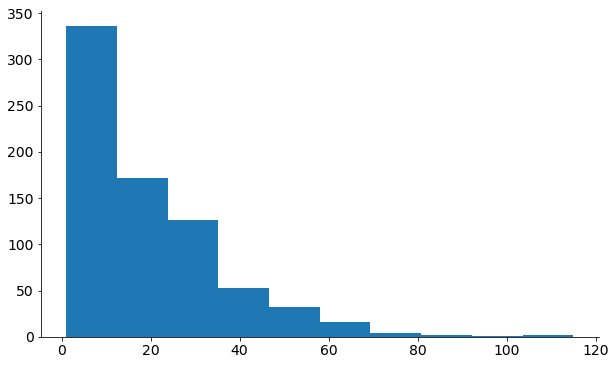

In [110]:
# drop respondents who have no missing
freq0_wo_zero = [v for v in freq0 if v>0]

# mean and median of missing months per respondent
print 'mean: %s, median: %s'%(np.mean(freq0_wo_zero), np.median(freq0_wo_zero))

# plot histogram
plt.hist(freq0_wo_zero)
remove_border()

### status 2 - working, with missing hours

In [111]:
freq2 = res_df.apply(lambda row: count_status_per_R(row, 2), axis=1)
print "%s respondents have no month working with missing hours"%sum([v==0 for v in freq2])

1090 respondents have no month working with missing hours


mean: 31.3111578947, median: 20.0


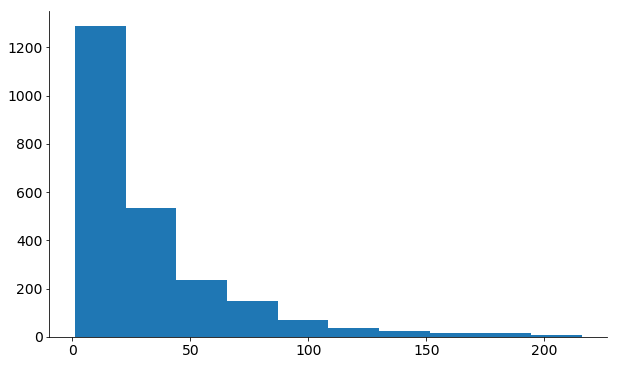

In [112]:
# drop respondents who have no month working with missing hours
freq2_wo_zero = [v for v in freq2 if v>0]

# mean and median of missing months per respondent
print 'mean: %s, median: %s'%(np.mean(freq2_wo_zero), np.median(freq2_wo_zero))

# plot histogram
plt.hist(freq2_wo_zero)
remove_border()

### status 6 - OOLF

In [119]:
freq6 = res_df.apply(lambda row: count_status_per_R(row, 6), axis=1)
print "%s respondents have no month working with missing hours"%sum([v==0 for v in freq6])

361 respondents have no month working with missing hours


mean: 77.6520618557, median: 65.0


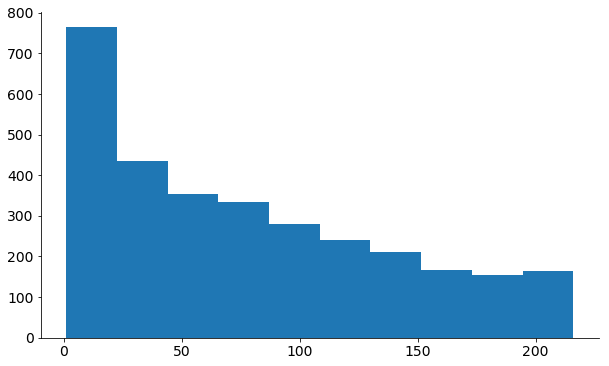

In [120]:
# drop respondents who have no month working with missing hours
freq6_wo_zero = [v for v in freq6 if v>0]

# mean and median of missing months per respondent
print 'mean: %s, median: %s'%(np.mean(freq6_wo_zero), np.median(freq6_wo_zero))

# plot histogram
plt.hist(freq6_wo_zero)
remove_border()